In [1]:
from rnn import MyGRU, MyLSTM, VanillaRNN, RNN
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
%load_ext autoreload
%autoreload 2

In [2]:
# Download the downsampled data frame from csv-file.
raw_data = pd.read_csv(r'C:\Users\romat\Documents\GitHub\HAMK_Smart_City\s-building_data.csv')

In [3]:
# View the data
raw_data

,index,Time,Floor_network_2_temperature,Radiator_network_1_temperature,Ventilation_network_1_temperature,Outside_temperature_average,District_heat_temperature,Domestic_water_network_1_primary_valve,Domestic_water_network_1_temperature,Inside_temperature,CO2_concentration,Energy_consumption,Outside_humidity,Solar_irradiance,Delayed_temperature
0,10809,2021-11-30 12:00:00+00:00,32.3,53.8,49.6,-10.000,91.6,29.9,57.8,21.883333,512.291667,109.0,83.0,3.5,21.695833
1,10810,2021-11-30 13:00:00+00:00,31.7,52.9,49.1,-11.000,91.3,28.8,58.1,21.837500,486.125000,107.0,84.0,0.7,21.708333
2,10811,2021-11-30 13:00:00+00:00,31.7,52.9,49.1,-11.000,91.3,28.8,58.1,21.837500,486.125000,108.0,84.0,0.7,21.708333
3,10812,2021-11-30 14:00:00+00:00,32.2,53.8,49.7,-11.000,91.4,27.4,58.1,21.770833,460.000000,111.0,85.0,0.4,21.700000
4,10813,2021-11-30 14:00:00+00:00,32.2,53.8,49.7,-11.000,91.4,27.4,58.1,21.770833,460.000000,114.0,85.0,0.4,21.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,13830,2022-02-13 12:00:00+00:00,27.8,37.9,38.5,1.070,80.9,28.9,58.0,21.287500,444.166667,66.0,94.0,-1.0,21.262500
2684,13831,2022-02-13 13:00:00+00:00,28.4,38.8,38.1,0.731,81.6,28.1,58.0,21.308333,444.500000,63.0,95.0,0.0,21.279167
2685,13832,2022-02-13 14:00:00+00:00,28.4,38.1,38.6,0.516,81.0,28.7,58.0,21.291667,438.833333,64.0,94.0,0.7,21.262500
2686,13833,2022-02-13 15:00:00+00:00,28.2,39.1,39.4,0.423,81.0,29.4,57.9,21.291667,448.875000,63.0,95.0,-2.2,21.254167


In [4]:
# Recreate a dataset as if the offsets did not exist. Save indices for the research of the efficiency.
nooffset_data = raw_data.copy()
future_indexes = []

def restore_offset(dataset, index_array, temperature, start, end = None):
    if end != None:
        dataset.loc[(dataset.Time >= start) & (dataset.Time < end), "Radiator_network_1_temperature"] += temperature
        index_array.append(((dataset.Time >= start) & (dataset.Time < end)).sum())
    else:
        dataset.loc[dataset.Time >= start, "Radiator_network_1_temperature"] += temperature
        index_array.append((dataset.Time >= start).sum())
        
restore_offset(nooffset_data, future_indexes, 3, "2022-01-13 12:00:00", "2022-01-20 11:00:00")
restore_offset(nooffset_data, future_indexes, 4, "2022-01-20 11:00:00", "2022-01-28 09:00:00")
restore_offset(nooffset_data, future_indexes, 5, "2022-01-28 09:00:00", "2022-02-08 11:00:00")
restore_offset(nooffset_data, future_indexes, 6, "2022-02-08 11:00:00")

In [5]:
future_indexes

[317, 308, 266, 111]

In [6]:
# Initialize the model with the required parameters.
hvac_model = MyGRU(quant=['Inside_temperature'], seq=12, fut=0, parameters=['Outside_humidity',
              'Solar_irradiance',
              'CO2_concentration',
              'hours_sin',
              'hours_cos',
              'weekday_sin',
              'weekday_cos',
              'Domestic_water_network_1_primary_valve',
              'District_heat_temperature',
              'Outside_temperature_average',
              'Ventilation_network_1_temperature', 'Delayed_temperature',
              'Radiator_network_1_temperature'])
              
            
# Scale, split, and sequence the downsampled data frame.
x_train, y_train, x_test, y_test = hvac_model.preprocess(raw_data)

# Scale, split, and sequence the dataset without the offset data
no_x_train, no_y_train, no_x_test, no_y_test = hvac_model.preprocess(nooffset_data)

Shape of training data: (2139, 12, 13)
Shape of testing data: (525, 12, 13)
Shape of training data: (2139, 12, 13)
Shape of testing data: (525, 12, 13)


In [7]:
# Train the model using custom fit method. 
# Does hyperparameter optimization automatically in pre-defined search space. Comment row below, if you have already trained the model.
hvac_model.fit(X=x_train, y=y_train, epochs=1000, max_trials=15)
hvac_model.save()

Trial 15 Complete [00h 01m 12s]
val_loss: 0.01672580251470208

Best val_loss So Far: 0.01601501302793622
Total elapsed time: 00h 25m 39s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:\Users\romat\Documents\GitHub\HAMK_Smart_City\GRU_Inside_temperature_2022-02-23
Showing 15 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 120
layers: 1
activation function: tanh
learning rate: 0.01
Score: 0.01601501302793622
Trial summary
Hyperparameters:
units: 20
layers: 1
activation function: tanh
learning rate: 0.01
Score: 0.016508397471625358
Trial summary
Hyperparameters:
units: 90
layers: 1
activation function: tanh
learning rate: 0.01
Score: 0.01672580251470208
Trial summary
Hyperparameters:
units: 40
layers: 1
activation function: tanh
learning rate: 0.1
Score: 0.01684276481391862
Trial summary
Hyperparameters:
units: 60
layers: 1
activation function: tanh
learning rate: 0.1
Score: 0.017260969284689055
Trial summary
Hyperparameter

# Save the object to folder in the root of the working directory. Uncomment row below, if you have the model trained already.

In [7]:
hvac_model.load(r'C:\Users\romat\Documents\GitHub\HAMK_Smart_City\GRU_Energy_consumption_2022-02-16')

Model loaded.
Scaler loaded.
Other variables loaded.


In [16]:
# Calculating prediction intervals
rounds = 12     # Number of data instances to calculate prediction intervals to.

for i in range(rounds):
    
    # Calculating prediction percentiles and saving them to a csv file.
    hvac_model.prediction_interval(x_train, y_train, x_test[i])     # NB! The process is computationally intensive.

Savings prediction intervals to C:\Users\romat\Documents\GitHub\HAMK_Smart_City/GRU_Inside_temperature_2022-01-10.
Starting bootstrap 1/39
[[  18.66666667  563.1725     2153.93939394    5.            7.
     8.77435121   10.50484434  359.96603774  269.86666667  512.85367963
   242.09999657  499.5600029   529.40297796  430.04545599  508.77262877
    21.75252768]]
Starting bootstrap 2/39
[[  18.66666667  563.1725     2153.93939394    5.            7.
     8.77435121   10.50484434  359.96603774  269.86666667  512.85367963
   242.09999657  499.5600029   529.40297796  430.04545599  508.77262877
    21.82357386]]
Starting bootstrap 3/39
[[  18.66666667  563.1725     2153.93939394    5.            7.
     8.77435121   10.50484434  359.96603774  269.86666667  512.85367963
   242.09999657  499.5600029   529.40297796  430.04545599  508.77262877
    21.72552743]]
Starting bootstrap 4/39
[[  18.66666667  563.1725     2153.93939394    5.            7.
     8.77435121   10.50484434  359.96603774  26

[[  18.66666667  563.1725     2153.93939394    5.            7.
     8.77435121   10.50484434  359.96603774  269.86666667  512.85367963
   242.09999657  499.5600029   529.40297796  430.04545599  508.77262877
    21.79911169]]
Starting bootstrap 35/39
[[  18.66666667  563.1725     2153.93939394    5.            7.
     8.77435121   10.50484434  359.96603774  269.86666667  512.85367963
   242.09999657  499.5600029   529.40297796  430.04545599  508.77262877
    21.76736161]]
Starting bootstrap 36/39
[[  18.66666667  563.1725     2153.93939394    5.            7.
     8.77435121   10.50484434  359.96603774  269.86666667  512.85367963
   242.09999657  499.5600029   529.40297796  430.04545599  508.77262877
    21.76607829]]
Starting bootstrap 37/39
[[  18.66666667  563.1725     2153.93939394    5.            7.
     8.77435121   10.50484434  359.96603774  269.86666667  512.85367963
   242.09999657  499.5600029   529.40297796  430.04545599  508.77262877
    21.79821269]]
Starting bootstrap 38

TypeError: 'tuple' object is not callable

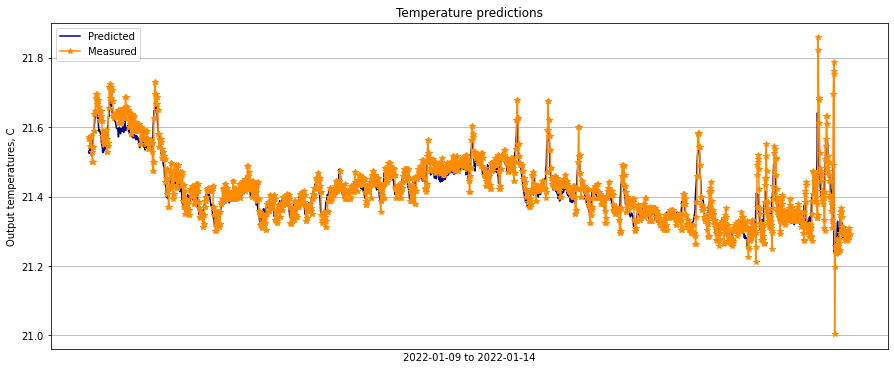

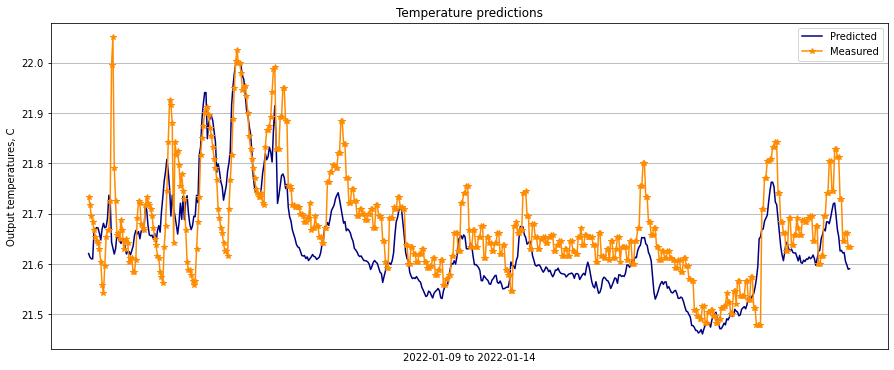

In [8]:
# Making test predictions with the RNN model.
# Predictions for the original data
train_preds = hvac_model.model.predict(x_train)
test_preds = hvac_model.model.predict(x_test)

# Predictions for the data without the offsets
no_train_preds = hvac_model.model.predict(no_x_train)
no_test_preds = hvac_model.model.predict(no_x_test)

# Loading prediction intervals from disk.
#low, up = hvac_model.load_intervals(r'C:\Users\romat\Documents\GitHub\HAMK_Smart_City\GRU_Inside_temperature_2022-01-10\pred_ints.csv')

# Inverse target variables both for measured values and computed predictions.
inv_preds_train, inv_y_train = hvac_model.inv_target(x_train, train_preds, y_train)
inv_preds_test, inv_y_test = hvac_model.inv_target(x_test, test_preds, y_test)

inv_no_preds_train, inv_no_y_train = hvac_model.inv_target(no_x_train, no_train_preds, no_y_train)
inv_no_preds_test, inv_no_y_test = hvac_model.inv_target(no_x_test, no_test_preds, no_y_test)

#low, up = hvac_model.inv_target(x_test, low, up)

# Plot model prediction alongside measured values.
# Add lower and upper intervals as arguments to plot them.
hvac_model.plot_preds(inv_preds_train, inv_y_train)
hvac_model.plot_preds(inv_preds_test, inv_y_test)

In [9]:
# Select the timeframe when the network was subjected to offsets
y1 = raw_data["Radiator_network_1_temperature"].iloc[-(np.sum(future_indexes)):]
y2 = nooffset_data["Radiator_network_1_temperature"].iloc[-(np.sum(future_indexes)):]
x = raw_data["Time"].iloc[-(np.sum(future_indexes)):]

Text(0.5, 1.0, 'Energy consumption with and without radiator network offsets')

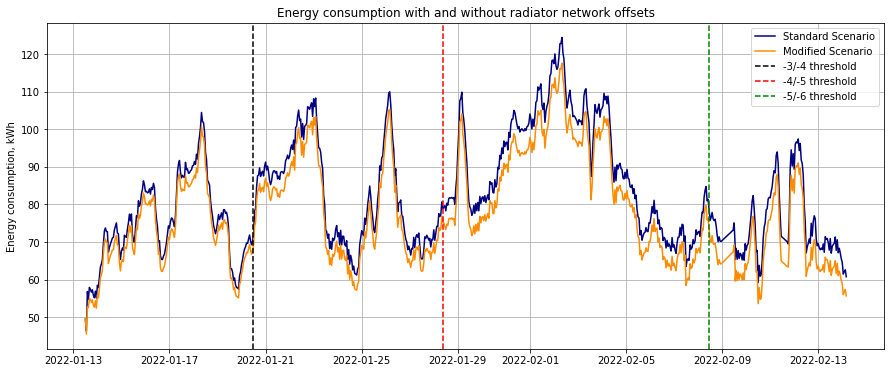

In [10]:
# Plot energy consumption between different offsets
plt.figure(figsize=(15, 6))
plt.plot(x, inv_no_preds_train[-(np.sum(future_indexes)):], color='navy', label='Standard Scenario')
plt.plot(x, inv_preds_train[-(np.sum(future_indexes)):], color='darkorange', label='Modified Scenario')
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 1, 20, 11, 0)), ls = "--", c = "black", label="-3/-4 threshold")
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 1, 28, 9, 0)), ls = "--", c = "red", label="-4/-5 threshold")
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 2, 8, 11, 0)), ls = "--", c = "green", label="-5/-6 threshold")
plt.legend()
plt.grid()
plt.ylabel("Energy consumption, kWh")
plt.title("Energy consumption with and without radiator network offsets")

In [11]:
(future_indexes)

[167, 190, 266, 123]

In [ ]:
# Needs to be completed
def offset_efficiencies(indices):
    efficiencies = []
    indices = indices[::-1]
    efficiencies.append((inv_no_preds_train / inv_preds_train)[-(indices[0]):].mean())
    for i, z in zip(indices, range(1, len(indices))):
        efficiencies.append((inv_no_preds_train / inv_preds_train)[indices[z]:].mean())
    efficiencies = np.array(efficiencies)
    efficiencies = efficiencies * 100 - 100
    return efficiencies

In [16]:
efficiencies = []
efficiencies.append((inv_no_preds_train / inv_preds_train)[-123:].mean())
efficiencies.append((inv_no_preds_train / inv_preds_train)[-(266+123):-123].mean())
efficiencies.append((inv_no_preds_train / inv_preds_train)[-(190+266+123):-(123+190)].mean())
efficiencies.append((inv_no_preds_train / inv_preds_train)[-(167+190+266+123):-(167+123+190)].mean())

In [17]:
efficiencies = efficiencies[::-1]

In [18]:
efficiencies = np.array(efficiencies)

In [19]:
efficiencies = efficiencies * 100 - 100

In [20]:
offsets = ["-3", "-4", "-5", "-6"]

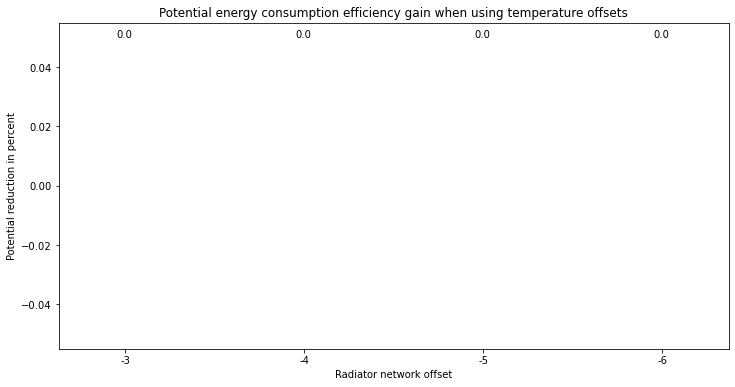

In [21]:
plt.figure(figsize=(12, 6))
plt.bar(offsets, efficiencies.round(1), width = 0.4)
plt.title('Potential energy consumption efficiency gain when using temperature offsets')
plt.ylabel("Potential reduction in percent")
plt.xlabel("Radiator network offset")
xlocs, xlabs = plt.xticks()
xlocs=[i for i in range(0,4)]
for i, v in enumerate(efficiencies.round(1)):
    plt.text(xlocs[i] - 0.05, v + 0.05, str(v))
plt.show()

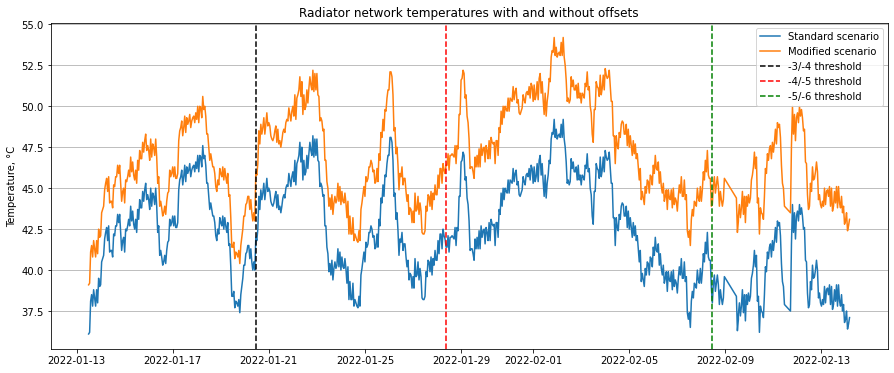

In [39]:
plt.figure(figsize = (15, 6))
plt.plot(x, y1, label = "Standard scenario")
plt.plot(x, y2, label = "Modified scenario")
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 1, 20, 11, 0)), ls = "--", c = "black", label="-3/-4 threshold")
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 1, 28, 9, 0)), ls = "--", c = "red", label="-4/-5 threshold")
plt.axvline(x = mdates.date2num(datetime.datetime(2022, 2, 8, 11, 0)), ls = "--", c = "green", label="-5/-6 threshold")
plt.title("Radiator network temperatures with and without offsets")
plt.ylabel("Temperature, °C")
plt.legend()
plt.grid(axis = "y")
plt.show()

In [9]:
print("Train MSE: " + str(mean_squared_error(inv_preds_train, inv_y_train)))
print("Test MSE: " + str(mean_squared_error(inv_preds_test, inv_y_test)))
print("Train MAE: " + str(mean_absolute_error(inv_preds_train, inv_y_train)))
print("Test MAE: " + str(mean_absolute_error(inv_preds_test, inv_y_test)))
print("Train MAPE: " + str(mean_absolute_percentage_error(inv_preds_train, inv_y_train)))
print("Test MAPE: " + str(mean_absolute_percentage_error(inv_preds_test, inv_y_test)))

Train MSE: 0.0016716423854480724
Test MSE: 0.00566907732264601
Train MAE: 0.02689119669261679
Test MAE: 0.06184309138968829
Train MAPE: 0.0012549524662301274
Test MAPE: 0.0028579845070458034
